In [120]:
import time
import functools
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Status:
# Ok, so I've disabled correction, set the process noise super low, solved the
# process model/jacobian on paper and written it all out in scalar form. This
# should work perfectly, so the issue is elsewhere.
#
# Things to check:
# - Confirm that scalar form works the same (and then revert to vector form).
# - Attitude parameter conversion routines.
# - All simulation data (yes this will suck).

In [121]:
def mrp2ep(m):
    m_mag = np.dot(m, m.T)
    return np.array([(1 - m_mag) / (1 + m_mag)] + [(2 * m_i) / (1 + m_mag) for m_i in m])

def mrp2dcm(m):
    m_mag = np.dot(m, m.T)
    skew = np.array((
        (0, -m[2], m[1]),
        (m[2], 0, -m[0]),
        (-m[1], m[0], 0)
    ))
    # R=eye(3) + ((4*(1-sqmag)*eye(3) + 8*skw)*skw)/(1+sqmag)^2
    # R=eye(3) + ((4*(1-sqmag)*eye(3) + 8*skw)*skw)/(1+sqmag)^2;
    return np.eye(3) + ((4 * (1 - m_mag) * np.eye(3) + 8 * skew) * skew) / ((1 + m_mag) ** 2)

def quat2dcm(q):
    q0, q1, q2, q3 = q
    return np.array([
        [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
    ])

def d_quat2dcm(q):
    q0, q1, q2, q3 = q
    
    # Partial derivatives of DCM w.r.t. quaternion components
    dR_dq = np.zeros((3, 3, 4))
    
    dR_dq[:, :, 0] = np.array([
        [ 2*q0,  2*q3, -2*q2],
        [-2*q3,  2*q0,  2*q1],
        [ 2*q2, -2*q1,  2*q0]
    ])
    
    dR_dq[:, :, 1] = np.array([
        [ 2*q1,  2*q2,  2*q3],
        [ 2*q2, -2*q1, -2*q0],
        [ 2*q3,  2*q0, -2*q1]
    ])
    
    dR_dq[:, :, 2] = np.array([
        [-2*q2,  2*q1,  2*q0],
        [ 2*q1,  2*q2,  2*q3],
        [-2*q0,  2*q3, -2*q2]
    ])
    
    dR_dq[:, :, 3] = np.array([
        [-2*q3, -2*q0,  2*q1],
        [ 2*q0, -2*q3,  2*q2],
        [ 2*q1,  2*q2,  2*q3]
    ])
    
    return dR_dq

In [123]:
# Load state data from sim.
time_s = np.load("data/time_s.npy")                    # Simulation time (s).
sigma_bn_mrp = np.load("data/sigma_bn_mrp.npy")        # Attitude MRP in inertial frame.
omega_bn_b = np.load("data/omega_bn_b.npy")            # Angular velocity of the spacecraft (rad/s).
r_bn_n = np.load("data/r_bn_n.npy")                    # Position of the s/c relative to Earth (m).
css_meas = np.load("data/css.npy")                     # Coarse Sun Sensor (CSS) data.
sun_vector_inertial = np.load("data/sun.npy")          # Position of the Sun relative to Earth (m).
tam_meas = np.load("data/tam.npy")                     # Three-axis Magnetometer (TAM) data.
mag_field_earth_fixed = np.load("data/mag_field.npy")  # Local magnetic field (T).

# Convert attitude data from MRP to EP.
q_bn = np.apply_along_axis(mrp2ep, axis=1, arr=sigma_bn_mrp)

# Convert angular rates from r/s to 

# Convert sun vector from inertial frame to body frame.
dcm_bn = np.apply_along_axis(mrp2dcm, axis=1, arr=sigma_bn_mrp)
sun_vector_relative = sun_vector_inertial - r_bn_n
sun_vector_body = np.array([np.matmul(dcm_bn[i], sun_vector_relative[i]) for i in range(len(dcm_bn))])
sun_vector_body = np.array([sun_vector[i] / np.linalg.norm(sun_vector[i]) for i in range(len(dcm_bn))])

# Orientations of the coarse sun sensors.
css_vectors = np.array((
    (1, 0, 0), (-1, 0, 0),
    (0, 1, 0), (0, -1, 0),
    (0, 0, 1), (0, 0, -1),
))

# Spacecraft moment of inertia.
moi = np.array((
    (900., 0., 0.),
    (0., 800., 0.),
    (0., 0., 600.),
))

# Stack attitude and angular rates to form ground truth 7d state history.
state_gt = np.hstack((q_bn, omega_bn_b))

# Stack CSS and TAM measurements to form 9d measurements history.
meas = np.hstack((css_meas, tam_meas))

# Control inputs - empty for now.
controls = np.zeros_like(time_s)

[1.13972327e+11 9.05039863e+10 3.92344163e+10]
[-2845372.01726244  5301406.33464915  3714454.14550474]
[1.13975172e+11 9.04986848e+10 3.92307018e+10]
[1.13975172e+11 9.04986848e+10 3.92307018e+10]
[0.75615674 0.60040437 0.26027212]


In [193]:
class AttitudeEstimatorEKF:
    
    def __init__(self, css_orientations, sc_moment_of_inertia):
        self.css_ors = css_orientations
        self.sc_moi = sc_moment_of_inertia

    def _process_model(self, dt, x, u):
        q, w = x[:4], x[4:]
        q0, q1, q2, q3 = q
        Ix, Iy, Iz = np.diag(self.sc_moi)
        wx, wy, wz = w

        # Quaternion kinematics
        #W = np.array([
        #    [0,    -w[0], -w[1], -w[2]],
        #    [w[0],  0,     w[2], -w[1]],
        #    [w[1], -w[2],  0,     w[0]],
        #    [w[2],  w[1], -w[0],     0]
        #])
        #q_dot = 0.5 * W @ q
        #q_new = q + q_dot * dt
        q_new = np.empty_like(q)
        q_new[0] = q0 + 0.5 * (-q1*wx - q2*wy - q3*wz)
        q_new[1] = q1 + 0.5 * ( q0*wx + q2*wz - q3*wy)
        q_new[2] = q2 + 0.5 * ( q0*wy - q1*wz + q3*wx)
        q_new[3] = q3 + 0.5 * ( q0*wz + q1*wy - q2*wx)

        # Angular velocity dynamics
        #w_dot = np.linalg.inv(self.sc_moi) @ (np.cross(-w, self.sc_moi @ w))
        #w_new = w + w_dot * dt
        w_new = np.empty_like(w)
        w_new[0] = w[0] + (Iz - Iy) / Ix * wy * wz
        w_new[1] = w[1] + (Ix - Iz) / Iy * wx * wz
        w_new[2] = w[2] + (Iy - Ix) / Iz * wx * wy

        return np.concatenate([q_new, w_new])

    def _process_model_jacobian(self, dt, x, u):
        q, w = x[:4], x[4:]
        q0, q1, q2, q3 = q
        Ix, Iy, Iz = np.diag(self.sc_moi)
        wx, wy, wz = w
        
        F = np.zeros((7, 7))

        # Jacobian of quaternion kinematics
        #W = np.array([
        #    [0,    -w[0], -w[1], -w[2]],
        #    [w[0],  0,     w[2], -w[1]],
        #    [w[1], -w[2],  0,     w[0]],
        #    [w[2],  w[1], -w[0],     0]
        #])
        #dq_dq = np.eye(4) + 0.5 * W * dt
        F[0, 0] = 1
        F[0, 1] = -wx / 2
        F[0, 2] = -wy / 2
        F[0, 3] = -wz / 2
        F[1, 0] =  wx / 2
        F[1, 1] = 1
        F[1, 2] =  wz / 2
        F[1, 3] = -wy / 2
        F[2, 0] =  wy / 2
        F[2, 1] = -wz / 2
        F[2, 2] = 1
        F[2, 3] =  wx / 2
        F[3, 0] =  wz / 2
        F[3, 1] =  wy / 2
        F[3, 2] = -wx / 2
        F[3, 3] = 1

        # Jacobian of quaternion w.r.t. angular rates
        #dq_dw = 0.5 * dt * np.array([
        #    [-q[1], -q[2], -q[3]],
        #    [ q[0],  q[3], -q[2]],
        #    [-q[3],  q[0],  q[1]],
        #    [ q[2], -q[1],  q[0]]
        #])
        F[0, 4] = -q1 / 2
        F[0, 5] = -q2 / 2
        F[0, 6] = -q3 / 2
        F[1, 4] =  q0 / 2
        F[1, 5] = -q3 / 2
        F[1, 6] =  q2 / 2
        F[2, 4] =  q3 / 2
        F[2, 5] =  q0 / 2
        F[2, 6] = -q1 / 2
        F[3, 4] = -q2 / 2
        F[3, 5] =  q1 / 2
        F[3, 6] =  q0 / 2

        # Jacobian of angular rate dynamics
        #I_inv = np.linalg.inv(self.sc_moi)
        #dw_dw = np.eye(3) + dt * I_inv @ (np.cross(self.sc_moi @ w, np.eye(3)) - np.cross(w, self.sc_moi))
        #dw_dw = np.array((
        #    (0, (Iy - Iz) / Ix * wz, (Iy - Iz) / Ix * wy),
        #    ((Iz - Ix) / Iy * wz, 0, (Iz - Ix) / Iy * wx),
        #    ((Ix - Iy) / Iz * wy, (Ix - Iy) / Iz * wx, 0)
        #))
        #S_matrix = lambda x, y, z: np.array(((0, -z, y), (z, 0, -x), (-y, x, 0)))
        #dw_dw = np.eye(3) - dt * np.linalg.inv(self.sc_moi) \
        #    @ (self.sc_moi @ S_matrix(*w) + S_matrix(*(self.sc_moi @ w)))
        F[4, 4] = 1
        F[4, 5] = (Iz - Iy) / Ix * wz
        F[4, 6] = (Iz - Iy) / Ix * wy
        F[5, 4] = (Ix - Iz) / Iy * wz
        F[5, 5] = 1
        F[5, 6] = (Ix - Iz) / Iy * wx
        F[6, 4] = (Iy - Ix) / Iz * wy
        F[6, 5] = (Iy - Ix) / Iz * wx
        F[6, 6] = 1

        # Assemble full Jacobian
        #F[:4, :4] = dq_dq
        #F[:4, 4:] = dq_dw
        #F[4:, 4:] = dw_dw

        return F

    def _measurement_model(self, x, sun_vector_ref, mag_field_ref):
        q, w = x[:4], x[4:]

        # Ensure input vectors are unit vectors
        sun_vector_ref = sun_vector_ref / np.linalg.norm(sun_vector_ref)
        mag_field_ref = mag_field_ref / np.linalg.norm(mag_field_ref)

        # Compute DCM from quaternion
        dcm = quat2dcm(q)

        # CSS measurement model
        sun_vector_body = dcm @ sun_vector_ref
        css_measurements = np.maximum(0, self.css_ors @ sun_vector_body)

        # TAM measurement model
        mag_field_body = dcm @ mag_field_ref

        return np.concatenate([css_measurements, mag_field_body])

    def _measurement_model_jacobian(self, x, sun_vector_ref, mag_field_ref):
        q, w = x[:4], x[4:]

        # Ensure input vectors are unit vectors
        sun_vector_ref = sun_vector_ref / np.linalg.norm(sun_vector_ref)
        mag_field_ref = mag_field_ref / np.linalg.norm(mag_field_ref)

        # Compute DCM and its derivative
        dcm = quat2dcm(q)
        d_dcm = d_quat2dcm(q)

        # CSS Jacobian
        H_css = np.zeros((6, 7))
        sun_vector_body = dcm @ sun_vector_ref
        for i in range(6):
            if np.dot(self.css_ors[i], sun_vector_body) > 0:
                for j in range(4):
                    H_css[i, j] = np.dot(self.css_ors[i], d_dcm[:,:,j] @ sun_vector_ref)

        # TAM Jacobian
        H_tam = np.zeros((3, 7))
        for j in range(4):
            H_tam[:, j] = d_dcm[:,:,j] @ mag_field_ref

        # Combine Jacobians
        H = np.vstack([H_css, H_tam])

        return H

    def _prediction_step(self, dt, x, P, u):
        F = self._process_model_jacobian(dt, x, u)  # Linearize process model about x[k-1].
        x = self._process_model(dt, x, u)  # Advance state using full, nonlinear process model.
        P = F @ P @ F.T + Q  # Advance state covariance using linearized process model F.
        return x, P
    
    def _correction_step(self, dt, x, P, z, sun_vector_ref, mag_field_ref):
        # Linearize measurement model about predicted x.
        H = self._measurement_model_jacobian(x, sun_vector_ref, mag_field_ref)
        
        # Calculate measurement residual using full, nonlinear measurement model.
        y = z - self._measurement_model(x, sun_vector_ref, mag_field_ref)
        
        # Use Jacobian for all further calculations.
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(len(P)) - K @ H) @ P
        return x, P
        
    def estimate(self, dt, x, P, u, z, sun_vector_ref, mag_field_ref):
        x, P = self._prediction_step(dt, x, P, u)
        #x, P = self._correction_step(dt, x, P, z, sun_vector_ref, mag_field_ref)
        return x, P
    
    def simulate(self, t, x_init, P_init, Q, R, controls, measurements,
                 sun_vector_refs, mag_field_refs):
        # Set up containers to store estimates.
        estimates = np.zeros((len(t), len(x_init)))
        estimates_cov = np.zeros((len(t), len(x_init)))
        estimates[0] = x_init
        estimates_cov[0] = np.diag(P_init)
        
        # Initialize state and covariance.
        x, P = x_init, P_init
        
        for k in range(1, len(t)):
            dt = t[k] - t[k-1]
            u = controls[k]
            z = measurements[k]
            sun_vector_ref = sun_vector_refs[k]
            mag_field_ref = mag_field_refs[k]
            x, P = self.estimate(dt, x, P, u, z, sun_vector_ref, mag_field_ref)
            estimates[k] = x
            estimates_cov[k] = np.diag(P)
        
        return estimates, estimates_cov
    
    def plot(self, t, ground_truth, estimates, estimates_cov):
        plt.figure(figsize=(15, 20))
        plt.rc("font", size=20)
        
        plt.subplot(2, 1, 1)
        for i, (label, color) in enumerate((("qw", "red"), ("qx", "green"), ("qy", "blue"), ("qz", "yellow"))):
            plt.plot(t, ground_truth[:, i], label=f"{label} (true)", color=color, alpha=0.5)
            plt.plot(t, estimates[:, i], label=f"{label} (est.)", color=color, linestyle="--")
            plt.fill_between(t, estimates[:, 4] + estimates_cov[:, 4],
                             estimates[:, 4] - estimates_cov[:, 4], color=color, alpha=0.1)
            #plt.plot(t, estimates[:, i] - ground_truth[:, i], label=f"{label} error", color=color)
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Attitude Quaternion")
        
        plt.subplot(2, 1, 2)
        for i, (label, color) in enumerate((("wx", "red"), ("wy", "green"), ("wz", "blue"))):
            plt.plot(t, ground_truth[:, 4+i], label=f"{label} (true)", color=color, alpha=0.5)
            plt.plot(t, estimates[:, 4+i], label=f"{label} (est.)", color=color, linestyle="--")
            plt.fill_between(t, estimates[:, 4+i] + estimates_cov[:, 4+i],
                             estimates[:, 4+i] - estimates_cov[:, 4+i], color=color, alpha=0.1)
            #plt.plot(t, estimates[:, 4+i] - ground_truth[:, 4+i], label=f"{label} error", color=color)
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Angular Velocity (???)")

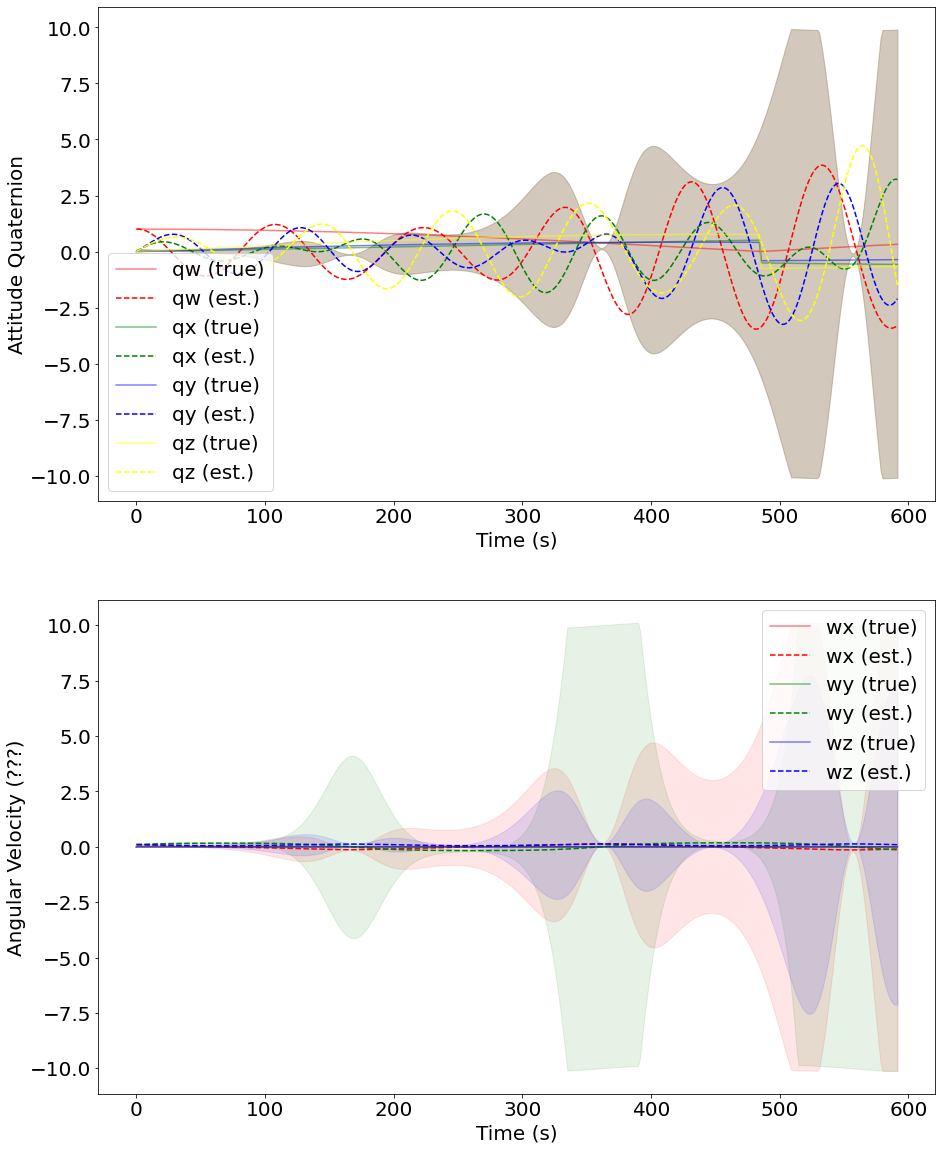

In [194]:
# Initial state and covariance estimates
x_init = np.array((1.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1))
P_init = np.diag((0.1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01))

# Process noise covariance
Q = np.diag((1e-6, 1e-6, 1e-6, 1e-6, 1e-4, 1e-4, 1e-4))

# Measurement noise covariance
R = np.diag((0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01))

ads = AttitudeEstimatorEKF(css_orientations=css_vectors, sc_moment_of_inertia=moi)
estimates, estimates_cov = ads.simulate(t=time_s, x_init=x_init, P_init=P_init, Q=Q, R=R,
                                        controls=controls, measurements=meas,
                                        sun_vector_refs=sun_vector_body,
                                        mag_field_refs=mag_field_earth_fixed)
np.clip(estimates, -10, 10, estimates)
np.clip(estimates_cov, -10, 10, estimates_cov)
ads.plot(t=time_s, ground_truth=state_gt, estimates=estimates, estimates_cov=estimates_cov)

In [104]:
class AttitudeEstimatorESEKF:
    
    def __init__(self, css_orientations, sc_moment_of_inertia):
        self.css_ors = css_orientations
        self.sc_moi = sc_moment_of_inertia

    def _quaternion_multiply(self, q1, q2):
        w1, x1, y1, z1 = q1
        w2, x2, y2, z2 = q2
        return np.array([
            w1*w2 - x1*x2 - y1*y2 - z1*z2,
            w1*x2 + x1*w2 + y1*z2 - z1*y2,
            w1*y2 - x1*z2 + y1*w2 + z1*x2,
            w1*z2 + x1*y2 - y1*x2 + z1*w2
        ])

    def _quaternion_to_rotation_matrix(self, q):
        q0, q1, q2, q3 = q
        return np.array([
            [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q0*q3), 2*(q1*q3 + q0*q2)],
            [2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
            [2*(q1*q3 - q0*q2), 2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
        ])

    def _process_model(self, dt, x, u):
        q, w = x[:4], x[4:]
        
        # Quaternion kinematics
        Omega = np.array([
            [0, -w[0], -w[1], -w[2]],
            [w[0], 0, w[2], -w[1]],
            [w[1], -w[2], 0, w[0]],
            [w[2], w[1], -w[0], 0]
        ])
        q_dot = 0.5 * Omega @ q
        q_new = q + dt * q_dot
        q_new /= np.linalg.norm(q_new)
        
        # Angular velocity dynamics
        w_dot = np.linalg.inv(self.sc_moi) @ (np.cross(self.sc_moi @ w, w) + u)
        w_new = w + dt * w_dot
        
        return np.concatenate([q_new, w_new])

    def _error_state_jacobian(self, dt, x):
        q, w = x[:4], x[4:]
        
        # Quaternion error state transition
        Omega = np.array([
            [0, -w[0], -w[1], -w[2]],
            [w[0], 0, w[2], -w[1]],
            [w[1], -w[2], 0, w[0]],
            [w[2], w[1], -w[0], 0]
        ])
        F_att = scipy.linalg.expm(0.5 * dt * Omega)[:3, :3]
        
        # Angular velocity error state transition
        I_inv = np.linalg.inv(self.sc_moi)
        F_w = np.eye(3) + dt * I_inv @ (np.cross(self.sc_moi @ w, np.eye(3)) - np.cross(w, self.sc_moi))
        
        # Assemble full error state transition matrix
        F = np.zeros((6, 6))
        F[:3, :3] = F_att
        F[3:, 3:] = F_w
        
        return F

    def _measurement_model(self, x, sun_vector_ref, mag_field_ref):
        q, w = x[:4], x[4:]
        
        R = self._quaternion_to_rotation_matrix(q)
        
        # CSS measurement model
        sun_vector_body = R @ sun_vector_ref
        css_measurements = np.maximum(0, self.css_ors @ sun_vector_body)
        
        # Normalize CSS measurements
        css_sum = np.sum(css_measurements)
        if css_sum > 0:
            css_measurements /= css_sum
        
        # TAM measurement model
        mag_field_body = R @ mag_field_ref
        
        return np.concatenate([css_measurements, mag_field_body])

    def _measurement_model_jacobian(self, x, sun_vector_ref, mag_field_ref):
        q, w = x[:4], x[4:]
        
        R = self._quaternion_to_rotation_matrix(q)
        sun_vector_body = R @ sun_vector_ref
        
        # CSS Jacobian
        H_css = np.zeros((6, 6))
        css_measurements = np.maximum(0, self.css_ors @ sun_vector_body)
        css_sum = np.sum(css_measurements)
        
        if css_sum > 0:
            for i in range(6):
                if css_measurements[i] > 0:
                    partial_derivative = self.css_ors[i] @ np.cross(R @ sun_vector_ref, np.eye(3))
                    H_css[i, :3] = (partial_derivative * css_sum - css_measurements[i] * np.sum(partial_derivative)) / (css_sum ** 2)
        
        # TAM Jacobian
        H_tam = np.zeros((3, 6))
        H_tam[:, :3] = np.cross(R @ mag_field_ref, np.eye(3))
        
        # Combine Jacobians
        H = np.vstack([H_css, H_tam])
        
        return H

    def _prediction_step(self, dt, x, P, u):
        x_new = self._process_model(dt, x, u)
        F = self._error_state_jacobian(dt, x)
        P = F @ P @ F.T + self.Q
        return x_new, P
    
    def _correction_step(self, x, P, z, sun_vector_ref, mag_field_ref):
        H = self._measurement_model_jacobian(x, sun_vector_ref, mag_field_ref)
        z_pred = self._measurement_model(x, sun_vector_ref, mag_field_ref)
        
        y = z - z_pred
        S = H @ P @ H.T + self.R
        K = P @ H.T @ np.linalg.inv(S)
        
        delta_x = K @ y
        
        # Update quaternion
        dq = np.array([1, 0.5*delta_x[0], 0.5*delta_x[1], 0.5*delta_x[2]])
        dq /= np.linalg.norm(dq)
        x[:4] = self._quaternion_multiply(x[:4], dq)
        x[:4] /= np.linalg.norm(x[:4])
        
        # Update angular velocity
        x[4:] += delta_x[3:]
        
        # Update covariance
        P = (np.eye(6) - K @ H) @ P
        
        return x, P, y
        
    def estimate(self, dt, x, P, u, z, sun_vector_ref, mag_field_ref):
        x, P = self._prediction_step(dt, x, P, u)
        x, P, y = self._correction_step(x, P, z, sun_vector_ref, mag_field_ref)
        return x, P, y
    
    def simulate(self, t, x_init, P_init, Q, R, controls, measurements,
                 sun_vector_refs, mag_field_refs):
        self.Q = Q
        self.R = R
        
        estimates = np.zeros((len(t), len(x_init)))
        estimates_cov = np.zeros((len(t), 6))
        residuals = np.zeros((len(t), 9))
        
        estimates[0] = x_init
        estimates_cov[0] = np.diag(P_init)
        
        x, P = x_init, P_init
        
        for k in range(1, len(t)):
            dt = t[k] - t[k-1]
            u = controls[k]
            z = measurements[k]
            sun_vector_ref = sun_vector_refs[k]
            mag_field_ref = mag_field_refs[k]
            
            x, P, y = self.estimate(dt, x, P, u, z, sun_vector_ref, mag_field_ref)
            
            estimates[k] = x
            estimates_cov[k] = np.diag(P)
            residuals[k] = y
        
        return estimates, estimates_cov, residuals
    
    def plot(self, t, ground_truth, estimates, estimates_cov, residuals):
        plt.figure(figsize=(15, 20))
        plt.rc("font", size=12)
        
        # Attitude plot
        plt.subplot(4, 1, 1)
        for i, (label, color) in enumerate((("qw", "red"), ("qx", "green"), ("qy", "blue"), ("qz", "yellow"))):
            plt.plot(t, ground_truth[:, i], label=f"{label} (true)", color=color, alpha=0.5)
            plt.plot(t, estimates[:, i], label=f"{label} (est.)", color=color, linestyle="--")
            if i > 0:
                plt.fill_between(t, estimates[:, i] + 3*np.sqrt(estimates_cov[:, i-1]),
                                 estimates[:, i] - 3*np.sqrt(estimates_cov[:, i-1]), color=color, alpha=0.1)
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Attitude Quaternion")
        plt.title("Attitude Estimation")
        
        # Angular velocity plot
        plt.subplot(4, 1, 2)
        for i, (label, color) in enumerate((("wx", "red"), ("wy", "green"), ("wz", "blue"))):
            plt.plot(t, ground_truth[:, 4+i], label=f"{label} (true)", color=color, alpha=0.5)
            plt.plot(t, estimates[:, 4+i], label=f"{label} (est.)", color=color, linestyle="--")
            plt.fill_between(t, estimates[:, 4+i] + 3*np.sqrt(estimates_cov[:, 3+i]),
                             estimates[:, 4+i] - 3*np.sqrt(estimates_cov[:, 3+i]), color=color, alpha=0.1)
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Angular Velocity (rad/s)")
        plt.title("Angular Velocity Estimation")
        
        # Residuals plot
        plt.subplot(4, 1, 3)
        for i in range(6):
            plt.plot(t, residuals[:, i], label=f"CSS {i+1}")
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("CSS Residual")
        plt.title("CSS Measurement Residuals")
        
        plt.subplot(4, 1, 4)
        for i in range(3):
            plt.plot(t, residuals[:, i+6], label=f"TAM {i+1}")
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("TAM Residual")
        plt.title("TAM Measurement Residuals")
        
        plt.tight_layout()
        plt.show()

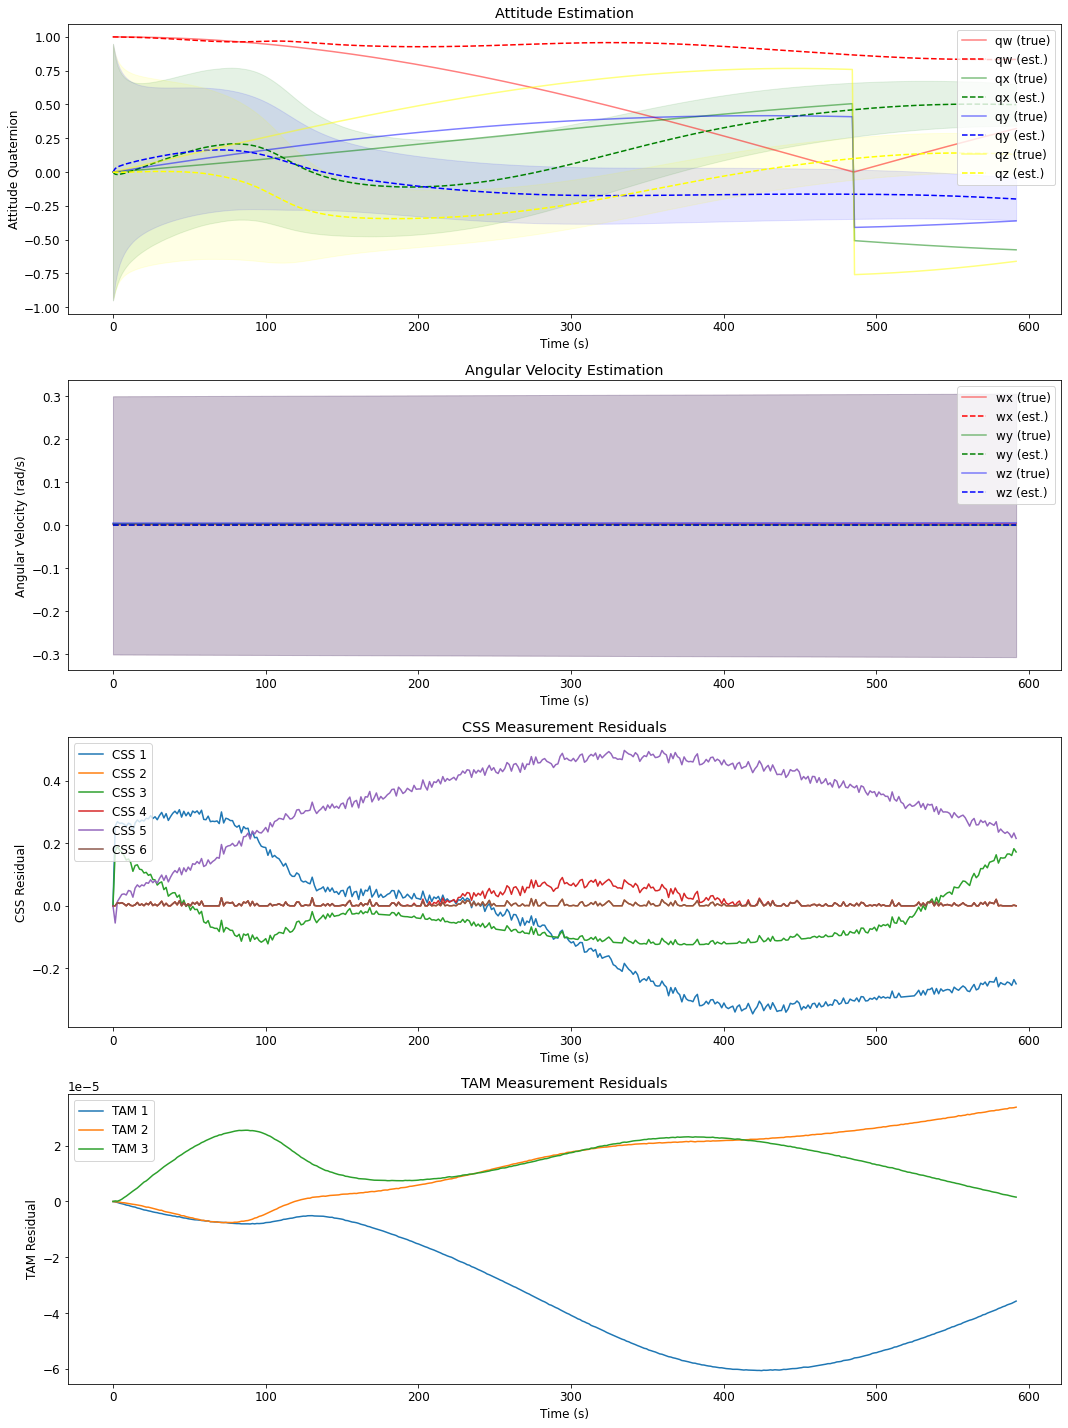

In [105]:
ads = AttitudeEstimatorESEKF(css_orientations=css_vectors, sc_moment_of_inertia=moi)

x_init = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
P_init = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])
Q = np.diag([1e-8, 1e-8, 1e-8, 1e-6, 1e-6, 1e-6])
R = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01])

estimates, estimates_cov, residuals = ads.simulate(t=time_s, x_init=x_init, P_init=P_init, Q=Q, R=R,
                                                   controls=controls, measurements=meas,
                                                   sun_vector_refs=sun_vector_body,
                                                   mag_field_refs=mag_field_earth_fixed)
ads.plot(t=time_s, ground_truth=state_gt, estimates=estimates, estimates_cov=estimates_cov, residuals=residuals)